# XGBoost Baseline

In [43]:
#3.10.8
# Import necessary libraries
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap
import matplotlib.pyplot as plt
import matplotlib.dates

In [107]:
# new raw data
#pollution_data = pd.read_csv('/Users/takuyab/Downloads/Water_datasets/TPut_data.csv')
#pollution_data = pd.read_csv('/Users/takuyab/Downloads/Water_datasets/TPur_data.csv')
#pollution_data = pd.read_csv('/Users/takuyab/Downloads/Water_datasets/TKB_data.csv')
#pollution_data = pd.read_csv('/Users/takuyab/Downloads/Water_datasets/TH_data.csv')
#pollution_data = pd.read_csv('/Users/takuyab/Downloads/Water_datasets/TEB_data.csv')
#pollution_data = pd.read_csv('/Users/takuyab/Downloads/Water_datasets/TChP_data.csv')
#pollution_data = pd.read_csv('/Users/takuyab/Downloads/Water_datasets/TCaP_data.csv')
#pollution_data = pd.read_csv('/Users/takuyab/Downloads/Water_datasets/TBGP_data.csv')
pollution_data = pd.read_csv('/Users/takuyab/Downloads/Water_datasets/TBB_data.csv')

pollution_data.replace(' ', np.nan, inplace=True)
pollution_data.dropna(axis = 0, how ='any', inplace = True)
pollution_data = pollution_data.set_index("DATE TIME")
pollution_data['PRCP_AMT'] = pollution_data['PRCP_AMT'].astype(float) #check if site has precipitation before using this

# TPut/TKB/TH/TChP/TBGP/TBB
y = pollution_data.iloc[:,4]
envir = [0,1,2,3,5]
time = [6,7,8]
trig = [9,10,11,12]

# TPur/TCaP - NO PRECIPITATION DATA
#y = pollution_data.iloc[:,4]
#envir = [0,1,2,3]
#time = [5,6,7]
#trig = [8,9,10,11]

# TEB
#y = pollution_data.iloc[:,3]
#envir = [0,1,2,4]
#time = [5,6,7]
#trig = [8,9,10,11]

X = pollution_data.iloc[:, envir + time + trig]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle = False, random_state = 42)

print(X.columns)
print(pollution_data.columns)

Index(['TEMP', 'COND', 'PH', 'AMMONIUM', 'PRCP_AMT', 'Hour of Day',
       'Day of Week', 'Month of Year', 'Half Day sin', 'Half Day cos',
       'Year sin', 'Year cos'],
      dtype='object')
Index(['TEMP', 'COND', 'PH', 'AMMONIUM', 'DOO-MGL', 'PRCP_AMT', 'Hour of Day',
       'Day of Week', 'Month of Year', 'Half Day sin', 'Half Day cos',
       'Year sin', 'Year cos'],
      dtype='object')


In [108]:
# Define SMAPE function
def smape(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

# Define a custom evaluation metric for XGBoost
def smape_eval(y_pred, y_true):
    y_true = y_true.get_label()
    return 'smape', smape(y_true, y_pred)

def smape_objective(y_pred, y_true):
    y_true = y_true.get_label()
    grad = (y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true)) ** 2) * (np.abs(y_pred) + np.abs(y_true) + 2 * np.abs(y_pred - y_true))
    hess = 2 / ((np.abs(y_pred) + np.abs(y_true)) ** 2)
    return grad, hess

In [109]:
# Set the parameters for the XGBoost model
params = {
    'max_depth': 6,  # maximum depth of a tree
    'learning_rate': 0.1,  # step size shrinkage
    'subsample': 0.8,  # subsample ratio of the training instances
    'colsample_bytree': 0.8,  # subsample ratio of columns when constructing each tree
    'n_estimators': 100  # number of boosting rounds
}

# Initialize the model
model = xgb.XGBRegressor(objective='reg:squarederror', **params)

# Train the model
model.fit(
    X_train, y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_metric=smape_eval, 
    early_stopping_rounds=10, 
    verbose=True
)

# Predict on the test set
y_pred = model.predict(X_test)

# Predict on the training set
y_pred_train = model.predict(X_train)

# Calculate SMAPE
smape_value = smape(y_test, y_pred)
print(f"SMAPE: {smape_value:.4f}") # WTF IS SMAPE THE SAME EVERY TIME?!

[0]	validation_0-rmse:8.67265	validation_0-smape:74.20430	validation_1-rmse:8.78567	validation_1-smape:73.85900
[1]	validation_0-rmse:7.81134	validation_0-smape:62.12315	validation_1-rmse:7.94550	validation_1-smape:61.85039
[2]	validation_0-rmse:7.03660	validation_0-smape:52.60275	validation_1-rmse:7.18813	validation_1-smape:52.43657
[3]	validation_0-rmse:6.33990	validation_0-smape:44.93855	validation_1-rmse:6.49933	validation_1-smape:44.76718
[4]	validation_0-rmse:5.71480	validation_0-smape:38.66796	validation_1-rmse:5.91257	validation_1-smape:38.56727


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[5]	validation_0-rmse:5.15093	validation_0-smape:33.47927	validation_1-rmse:5.36525	validation_1-smape:33.41973
[6]	validation_0-rmse:4.64377	validation_0-smape:29.13346	validation_1-rmse:4.87381	validation_1-smape:29.13545
[7]	validation_0-rmse:4.18967	validation_0-smape:25.45079	validation_1-rmse:4.46231	validation_1-smape:25.59477
[8]	validation_0-rmse:3.78017	validation_0-smape:22.31568	validation_1-rmse:4.07096	validation_1-smape:22.51621
[9]	validation_0-rmse:3.41189	validation_0-smape:19.62648	validation_1-rmse:3.71899	validation_1-smape:19.85573
[10]	validation_0-rmse:3.08107	validation_0-smape:17.30987	validation_1-rmse:3.40902	validation_1-smape:17.54388
[11]	validation_0-rmse:2.78558	validation_0-smape:15.29388	validation_1-rmse:3.15282	validation_1-smape:15.59193
[12]	validation_0-rmse:2.51895	validation_0-smape:13.54510	validation_1-rmse:2.90862	validation_1-smape:13.88344
[13]	validation_0-rmse:2.28031	validation_0-smape:12.02257	validation_1-rmse:2.69161	validation_1-sma

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


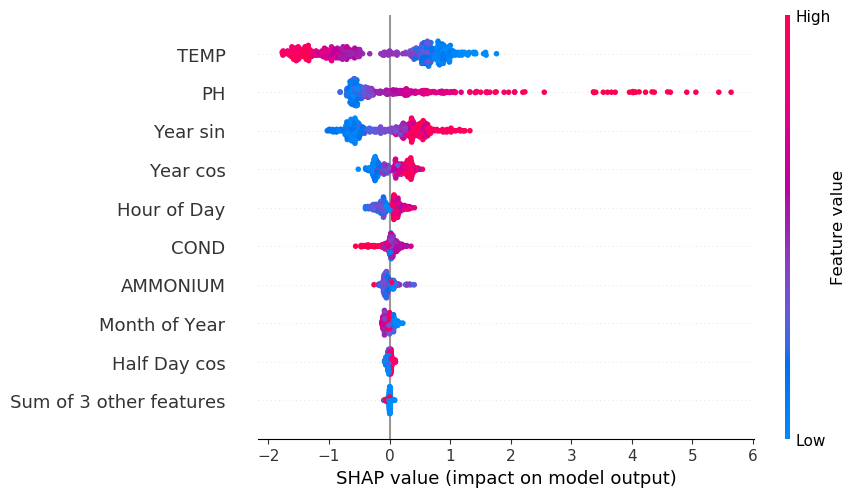

In [110]:
# SHAP feature importance
explainer = shap.Explainer(model)
shap_values = explainer(X_test.sample(500))

# Plot feature importance
shap.plots.beeswarm(shap_values)

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

Creating legend with loc="best" can be slow with large amounts of data.


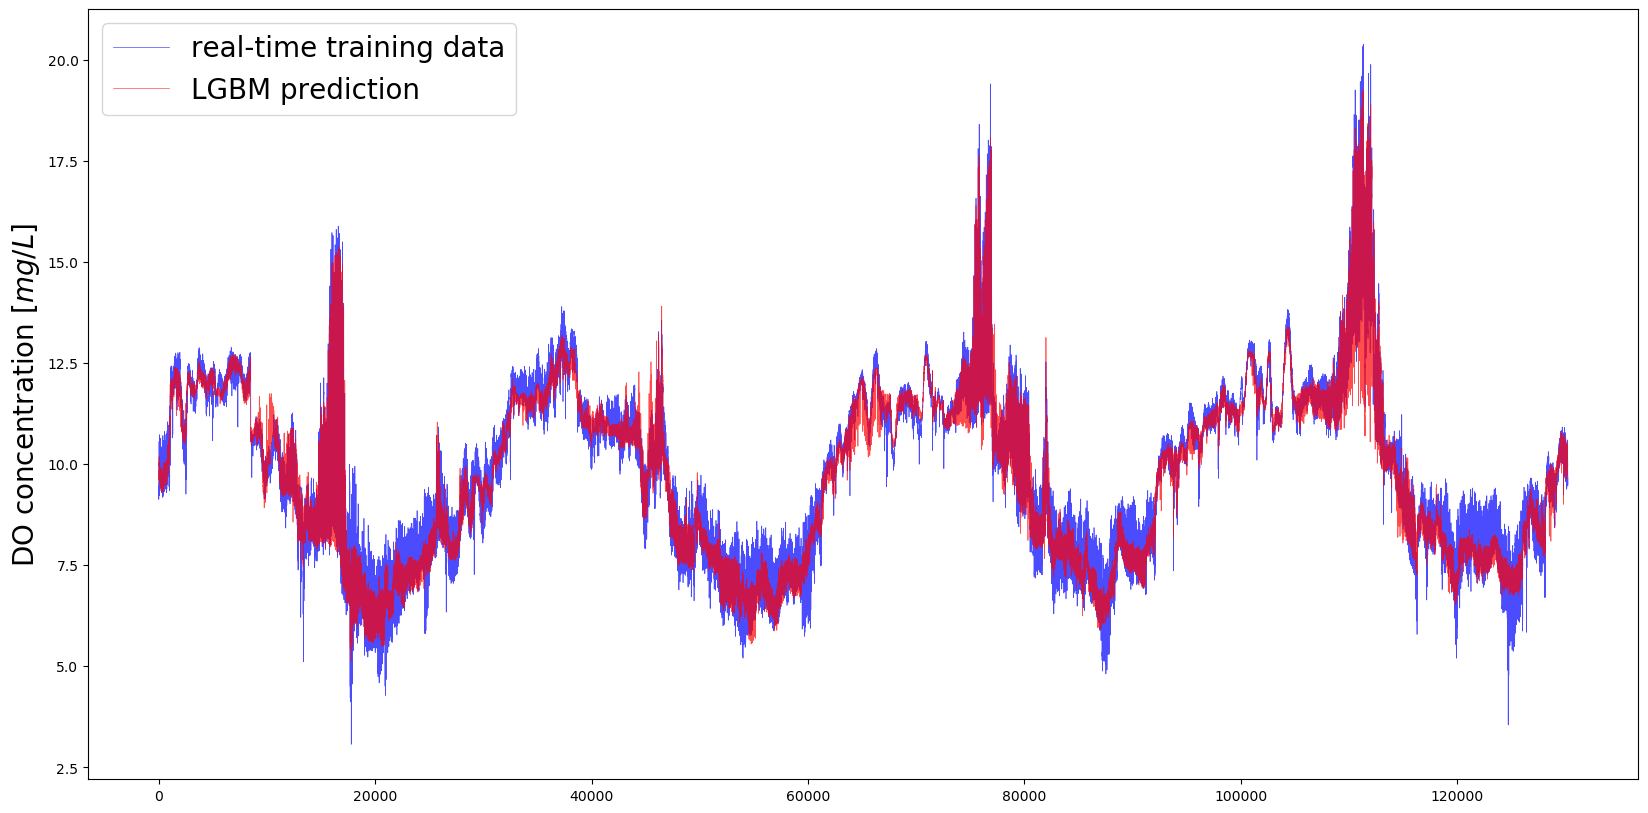

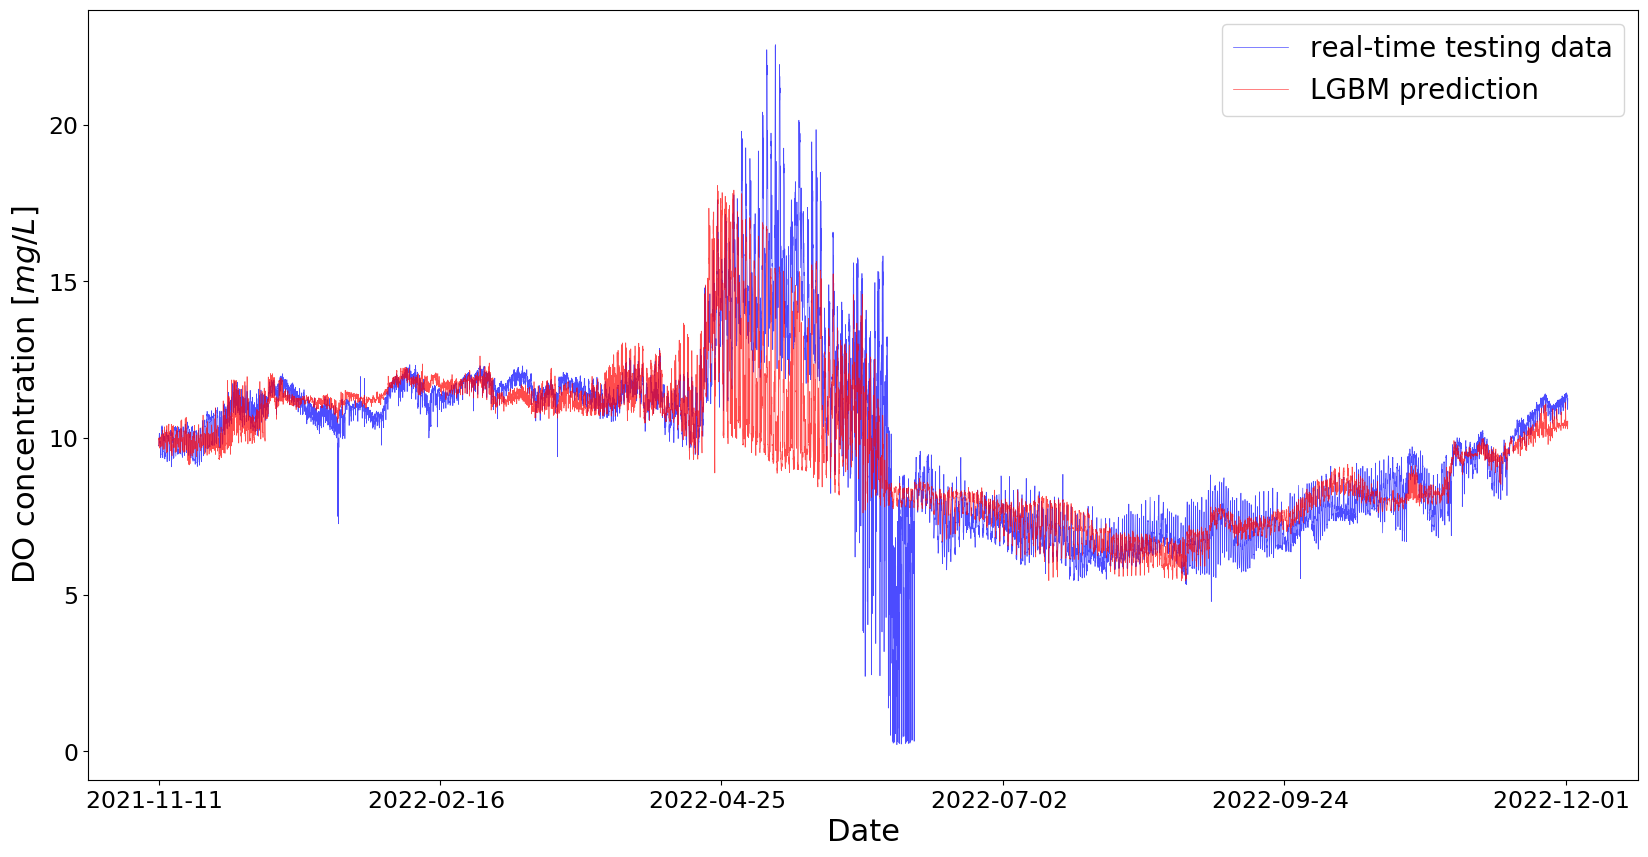

In [111]:
#plot timeseries - training data
fig, (ax) = plt.subplots(1, figsize=(20, 10))
ax.plot(np.array(y_train), color='b',label='real-time training data',linewidth=0.5,alpha=0.7)
ax.plot(np.array(y_pred_train), color='r',label='LGBM prediction',linewidth=0.5,alpha=0.7)

ax.legend(fontsize=20)
ax.set_ylabel('DO concentration [$mg/L$]',fontsize=20)

dates = [x[:11] for x in X_test.index]

#plot timeseries - test data
fig2, (ax2) = plt.subplots(1, figsize=(20, 10))
ax2.plot(X_test.index, np.array(y_test), color='b',label='real-time testing data',linewidth=0.5,alpha=0.7)
ax2.plot(X_test.index, np.array(y_pred), color='r',label='LGBM prediction',linewidth=0.5,alpha=0.7)

ax2.legend(fontsize=20)
ax2.set_ylabel('DO concentration [$mg/L$]',fontsize=22)
ax2.set_xlabel('Date',fontsize=22)

plt.xticks(np.arange(0, len(y_test) + 1, 6500), dates[::6500], fontsize=17)
plt.yticks(fontsize=17)
plt.tight_layout